In [184]:
import pandas as pd
import numpy as np

In [185]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [186]:
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
all_series = {
    "international-airline-passengers": airlines_passengers["Count"],
    "daily-total-female-births-in-cal": female_births["Count"]
}

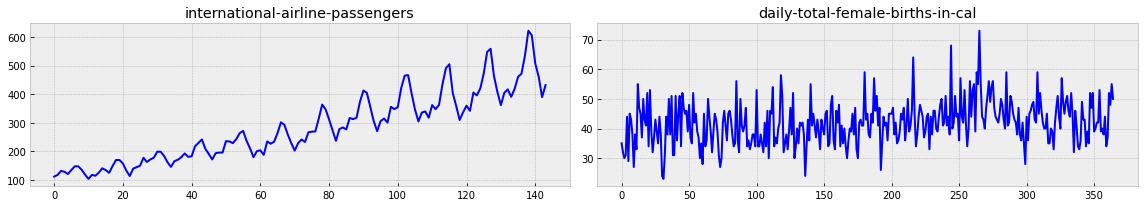

In [188]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

MA

In [189]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

WMA

In [190]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

EMA

In [191]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
# визуализируем

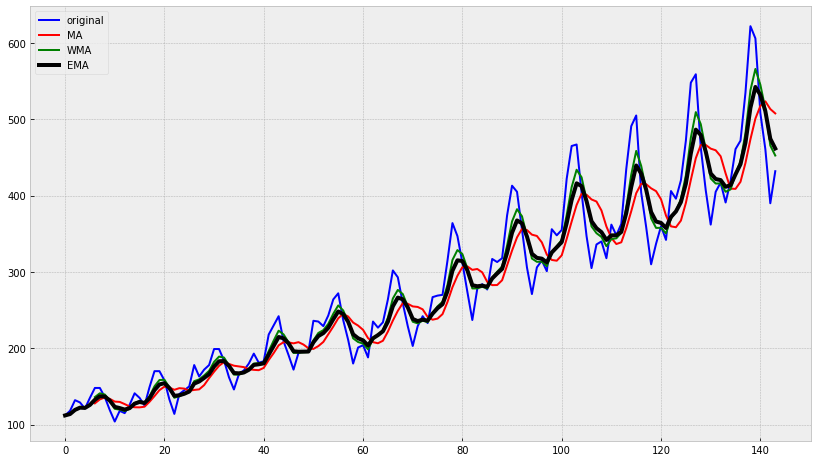

In [251]:
ema = exponential_moving_average(airlines_passengers["Count"], 0.3)
wma = weighted_moving_average(airlines_passengers["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(airlines_passengers["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

DEMA

In [252]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [253]:
def plot_dema(alpha, beta):
    dema = double_ema(airlines_passengers["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(airlines_passengers["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

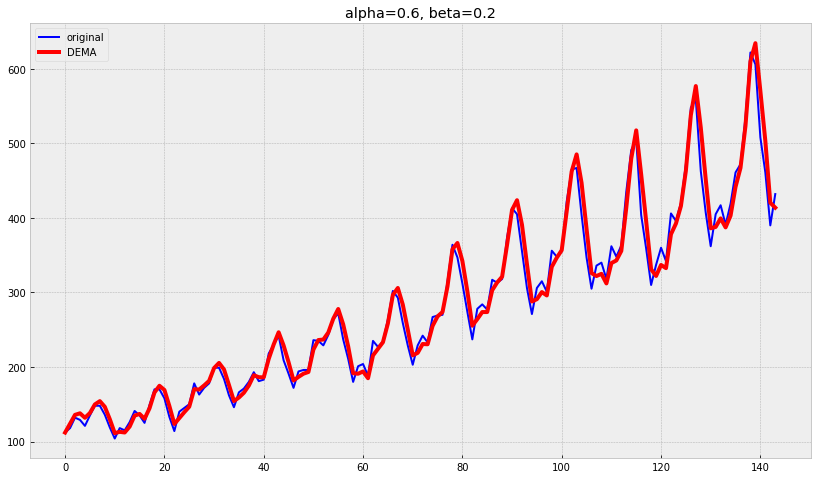

In [224]:
plot_dema(0.6, 0.2)

TEMA

In [225]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [254]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
   
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [255]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: 
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [256]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"], ser_to_plot=airlines_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

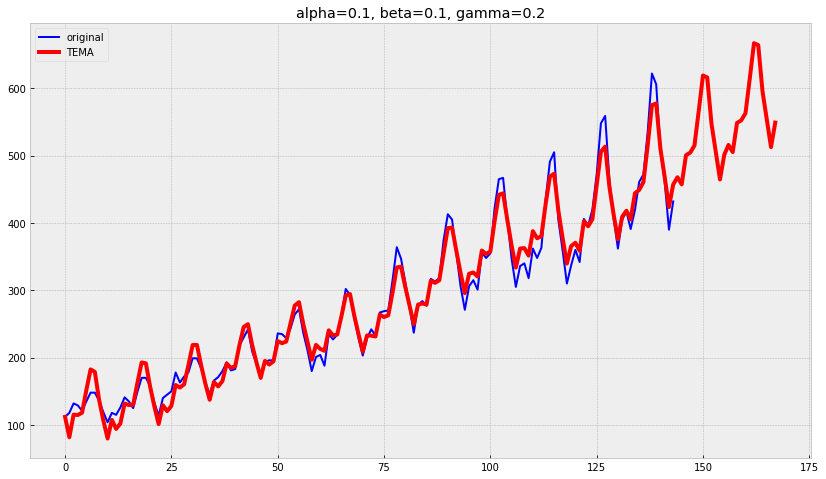

In [257]:
plot_tema(0.1, 0.1, 0.2)

# Подбор параметров

In [326]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [327]:
series = airlines_passengers["Count"]

In [328]:
len(series)

144

In [329]:
train, test, val = series[:115], series[115:125], series[125:]

In [333]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [334]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [335]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 433.64223009884233
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  653.67200966, -5260.76578925,  -309.72751532])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 17
     njev: 40
   status: 0
  success: True
        x: array([0.42827857, 0.00535144, 0.72713249])


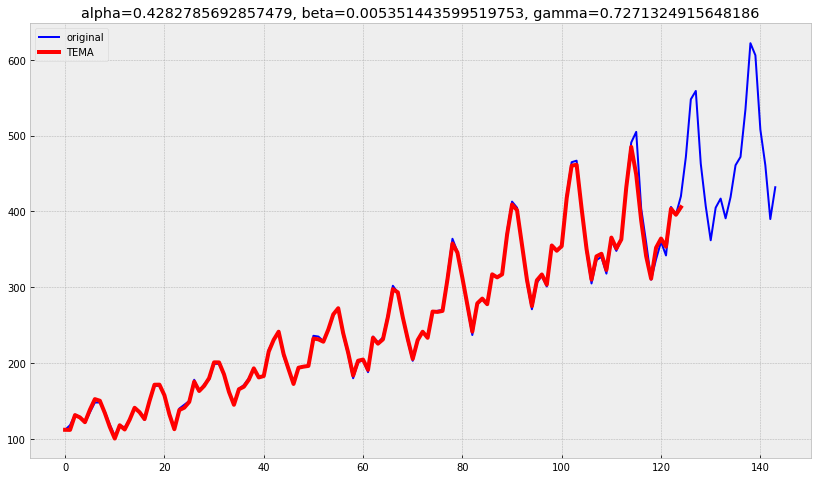

In [336]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:328], n_preds=len(test))

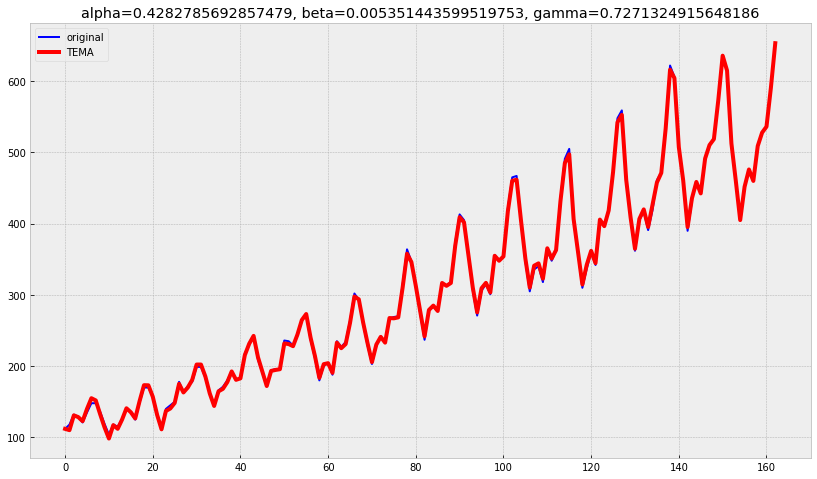

In [338]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:328], ser_to_plot=series, n_preds=len(val))

# Кросс-валидация

In [339]:
train, val = series[:328], series[328:]

In [340]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [341]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

52126.86290437809------------
51299.828326116025------------
52126.86290437809------------
52057.14891627752------------
51527.504140174795------------
51133.67965958415------------
50647.7553371427------------
50278.99130143911------------
49424.46295580842------------
49402.94068021807------------
48390.53093991907------------
47746.32862143762------------
46109.48585243547------------
45456.41665559426------------
43165.237928413604------------
42591.08623909162------------
39716.801880933606------------
38285.03709551645------------
34449.394102438------------
33261.60698755117------------
28924.286942938546------------
27528.65433760914------------
23047.594687915505------------
21443.495445034077------------
17327.058551892922------------
16227.130506360189------------
13015.586115720056------------
12104.308657136417------------
9884.165785542269------------
9297.701725550594------------
7939.538542102684------------
7620.379136899504------------
6882.8525658083845------------
6

In [342]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[0.25368709, 0.        , 1.        ],
       [0.2537479 , 0.        , 1.        ],
       [0.25376271, 0.        , 1.        ],
       [0.25366069, 0.        , 1.        ]]), array([4273.62008022, 4273.62008441, 4273.62009652, 4273.62010121]))
           fun: 4273.6200802169615
       message: 'Optimization terminated successfully.'
          nfev: 153
           nit: 81
        status: 0
       success: True
             x: array([0.25368709, 0.        , 1.        ])


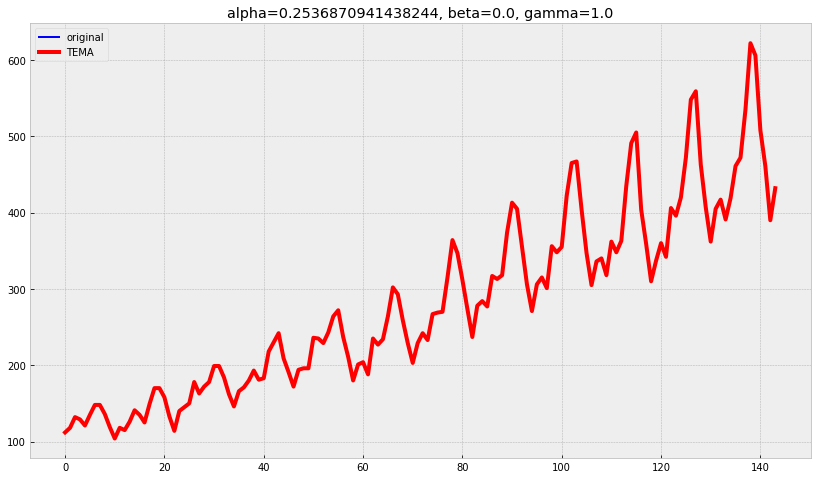

In [343]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))